# occupancy prediction - initial EDA

> Author: Trevor Bergstrom <br>
> Date: 2022-08-27 <br>
> Kernel: Python 3.10 <br>

## init

In [30]:
import os 
os.chdir('/Users/trevor/Work/1-projects/occupancy-prediction')

import numpy as np
import pandas as pd 
import pathlib 
import statsmodels as sm

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import altair as alt
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [4]:
DATASTORE = pathlib.Path('datastore')
assert DATASTORE.exists(), f'unable to find datastore at: {DATASTORE}'

## load data

In [39]:
data_path = DATASTORE.joinpath('occ-counts.csv')

df = (
    pd.read_csv(data_path, parse_dates=['timestamp']).rename(columns={'count': 'occ'})
    .query('location == "POP"')
    .query('5 < timestamp.dt.hour < 24')
    .drop(columns=['location', 'capacity', 'subLabel', 'lastUpdate'])
    .reindex(columns=['timestamp', 'occ'])
)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7160 entries, 0 to 22647
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7160 non-null   datetime64[ns]
 1   occ        7160 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 167.8 KB


None

,timestamp,occ
0,2022-03-28 16:02:42.738457,177
3,2022-03-28 16:04:30.367773,184
6,2022-03-28 16:04:53.611084,191
9,2022-03-28 16:11:59.003963,207
12,2022-03-28 16:22:04.569012,227


# exploration

## feature processing

In [103]:
fdf = (
    df
    .groupby(pd.Grouper(key='timestamp', freq='1H')).occ.mean()
    .fillna(0).reset_index()
    .assign(
        day = lambda d: d.timestamp.dt.strftime('%w').astype('int'),
        day_ = lambda d: d.timestamp.dt.strftime('%A'),
        hour = lambda d: d.timestamp.dt.strftime('%H').astype('int'),
    )
    # skip past section of missing data
    .loc[lambda d: d.timestamp >= pd.to_datetime('2022-05-01')]
)
fdf.head()

,timestamp,occ,day,day_,hour
800,2022-05-01 00:00:00,0.0,0,Sunday,0
801,2022-05-01 01:00:00,0.0,0,Sunday,1
802,2022-05-01 02:00:00,0.0,0,Sunday,2
803,2022-05-01 03:00:00,0.0,0,Sunday,3
804,2022-05-01 04:00:00,0.0,0,Sunday,4


## occupancy distributions

Text(0.5, 1.0, 'POP occupancy by day of week')

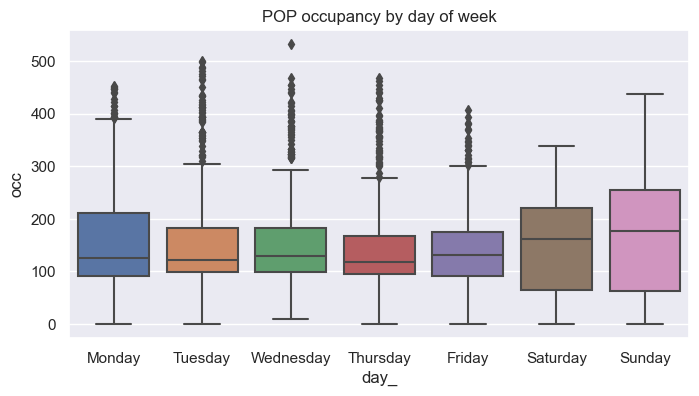

In [42]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=fdf, x='day_', y='occ')
plt.title('POP occupancy by day of week')

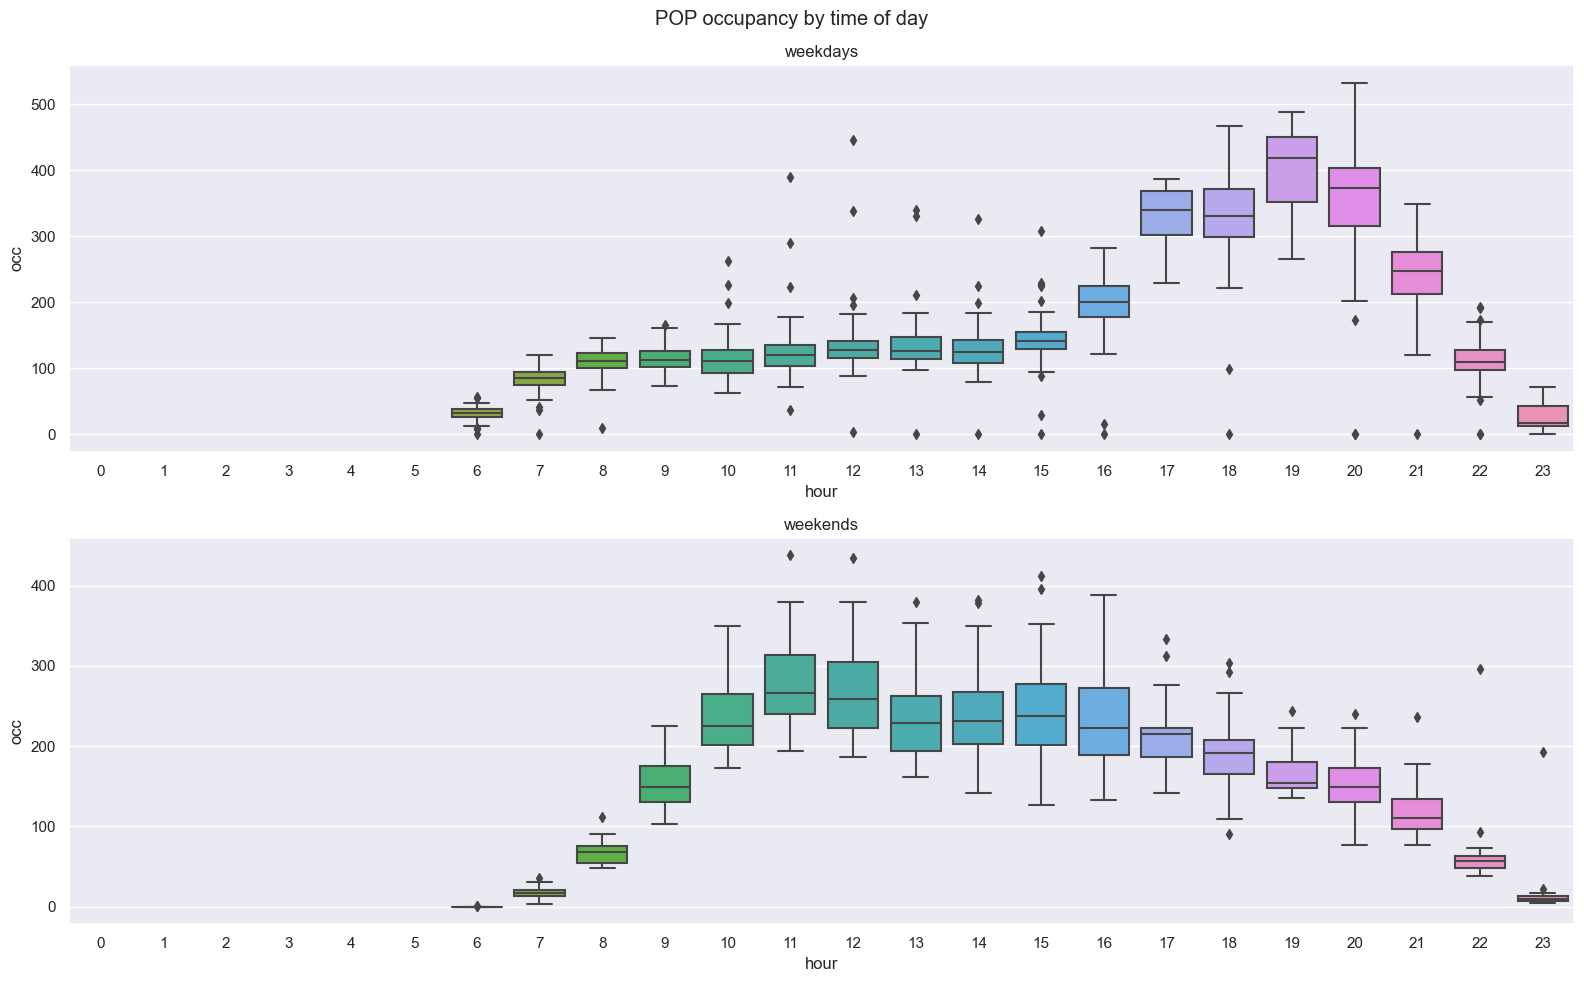

In [43]:
fig, (top, bottom) = plt.subplots(2, 1, figsize=(16, 10))

sns.boxplot(
    data=fdf.query('day_ not in ("Saturday", "Sunday")'), 
    x='hour', y='occ', ax=top,
)
top.set_title('weekdays')
sns.boxplot(
    data=fdf.query('day_ in ("Saturday", "Sunday")'), 
    x='hour', y='occ', ax=bottom,
)
bottom.set_title('weekends')
fig.suptitle('POP occupancy by time of day')
fig.tight_layout()

## stationarity

In [44]:
from statsmodels.tsa.stattools import adfuller

### rolling stats

<AxesSubplot:title={'center':'Occupancy trend with rolling mean and std'}, xlabel='timestamp'>

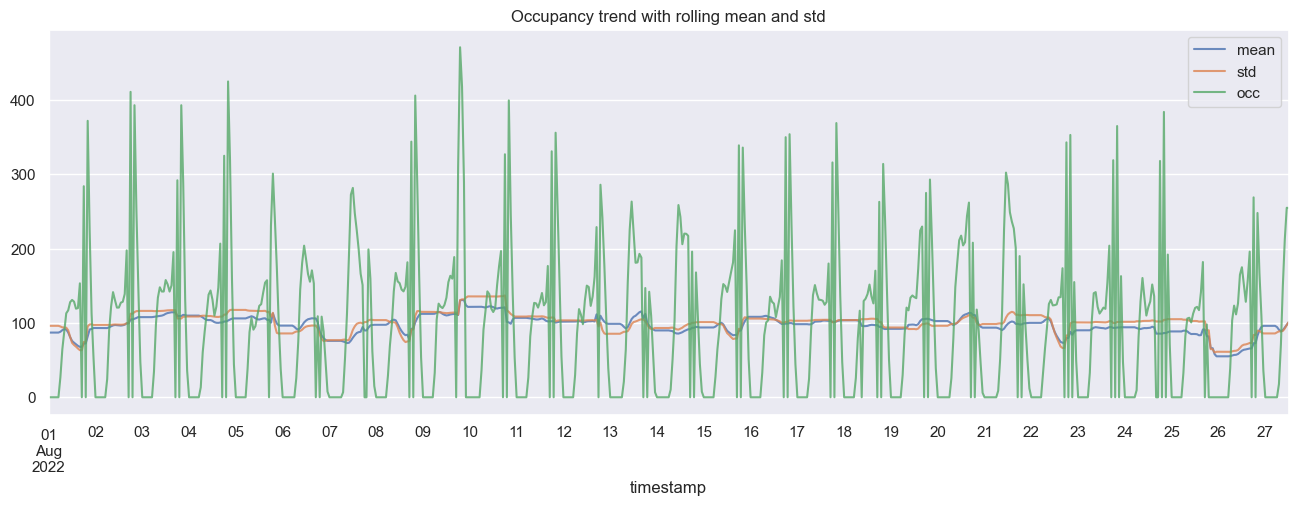

In [106]:
window_size = 24
start = '2022-08-01'

(
    fdf.set_index('timestamp')
    .occ.rolling(window=window_size).agg(['mean', 'std']).dropna()
    .merge(fdf.set_index('timestamp').occ, how='left', left_index=True, right_index=True)
    .loc[start:].plot(subplots=False, figsize=(16, 5), title='Occupancy trend with rolling mean and std', alpha=0.8)
)

### dickey-fuller test

In [84]:
test_stat, pval, lags, obs, _, _ = adfuller(fdf.set_index('timestamp').occ, autolag='AIC')
print(f'test statistic: {test_stat:0.2f}\np-value: {pval:0.2e}\nlags used: {lags}\nobs used: {obs:,}')

test statistic: -9.78
p-value: 6.68e-17
lags used: 20
obs used: 2,433


## seasonal decomposition

In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [117]:
orig = fdf.set_index('timestamp').occ
decomp = seasonal_decompose(orig)

decomp_df = (
    pd.DataFrame({
        'orig': orig,
        'trend': decomp.trend,
        'seasonal': decomp.seasonal,
        'resid': decomp.resid,
    })
    .dropna()
)
decomp_df.head()

,orig,trend,seasonal,resid
timestamp,,,,
2022-05-01 12:00:00,264.25,105.475694,70.138743,88.635562
2022-05-01 13:00:00,242.00,105.475694,60.057529,76.466777
2022-05-01 14:00:00,254.25,105.475694,56.646512,92.127794
2022-05-01 15:00:00,263.25,105.475694,68.111907,89.662398
2022-05-01 16:00:00,254.50,105.475694,97.428997,51.595308


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

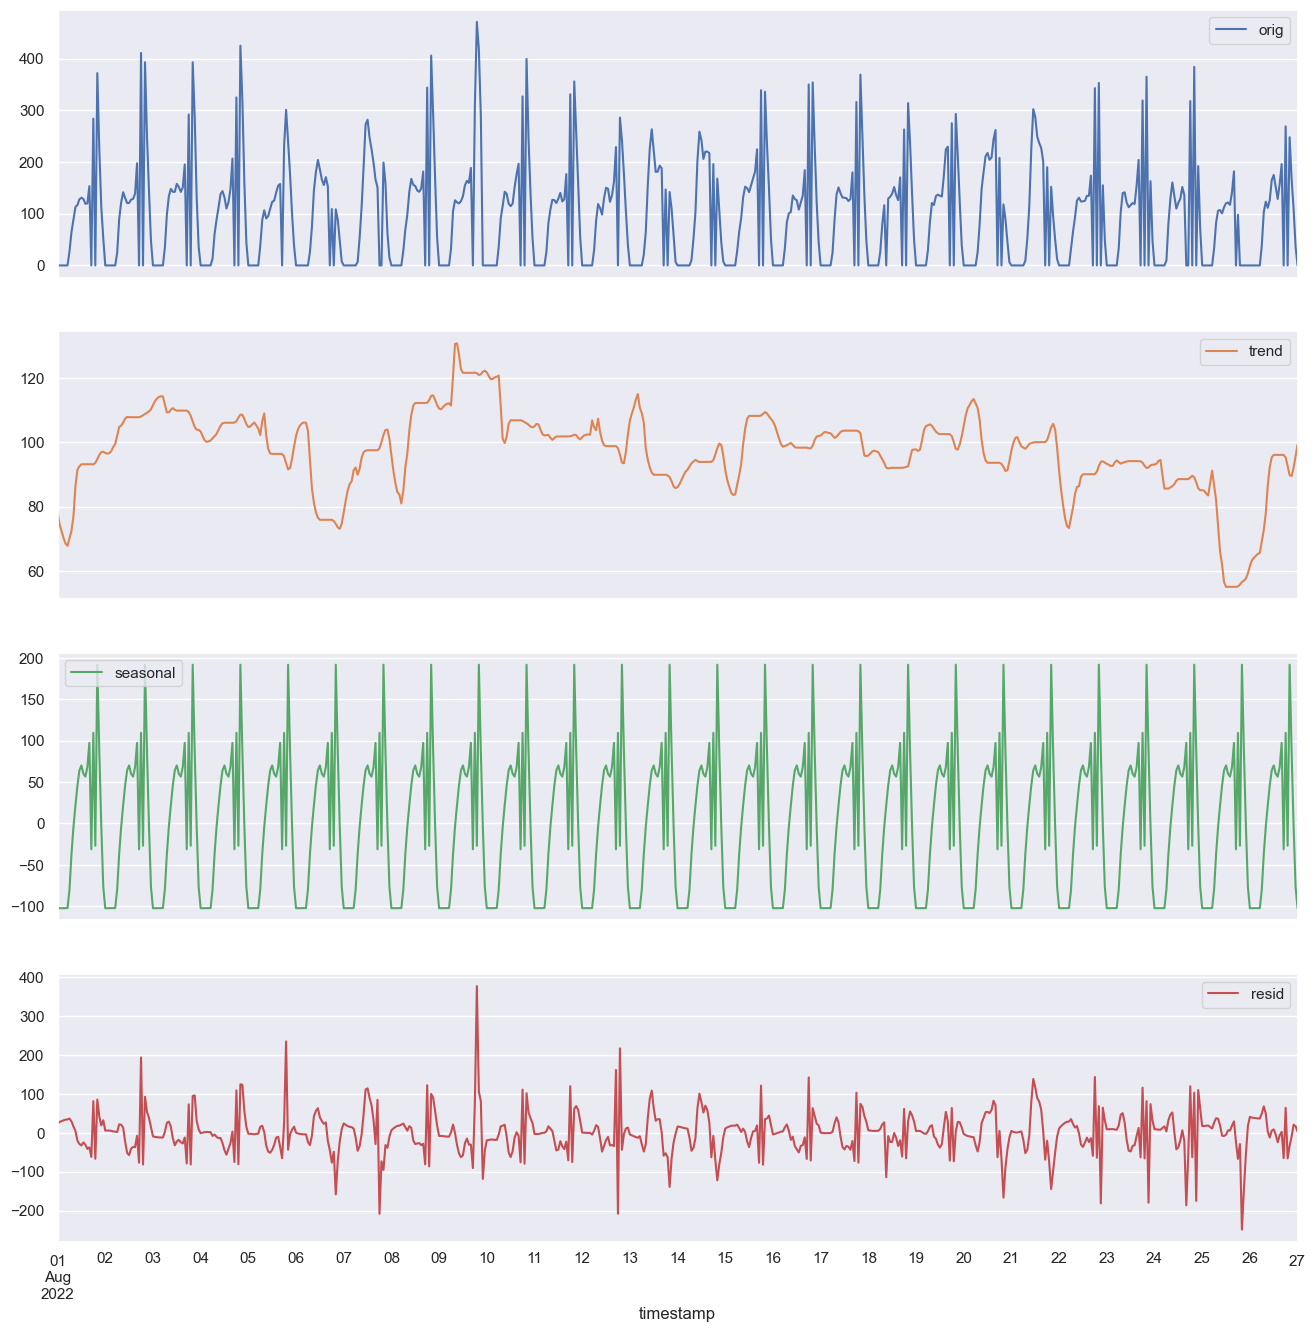

In [123]:
start = '2022-08-01'

(
    decomp_df.loc[start:]
    .plot(subplots=True, figsize=(16, 4 * 4))
)

## ACF & PACF plots

In [124]:
from statsmodels.tsa.stattools import acf, pacf

<AxesSubplot:>

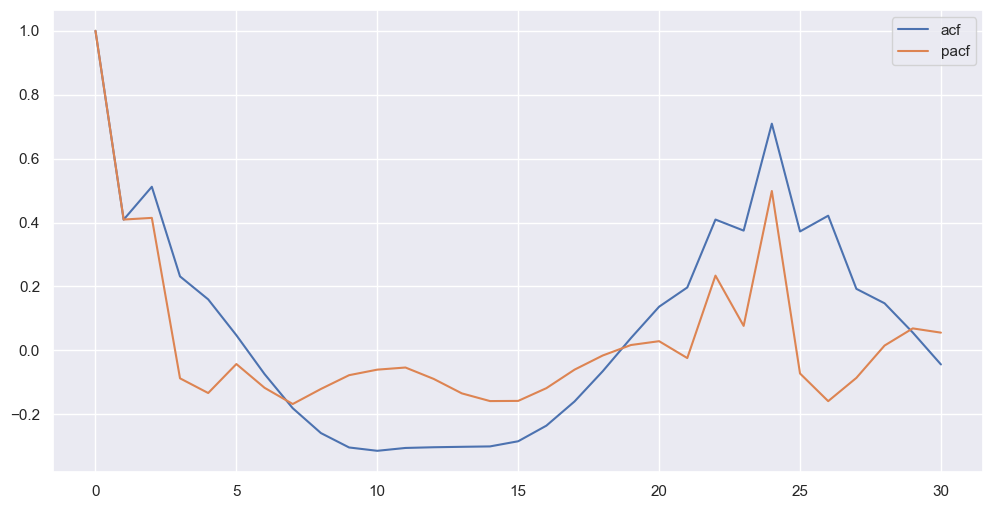

In [137]:
nlags = 30
orig = fdf.set_index('timestamp').occ

ac_df = pd.DataFrame({
    'acf': acf(orig, nlags=nlags), 
    'pacf': pacf(orig, nlags=nlags, method='ols'),
})
ac_df.plot(subplots=False, figsize=(12, 6))